In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["WANDB_DISABLED"] = "true"

import sys
sys.path = [
    p for p in sys.path
    if p not in ['/home/jxm3/research/prompting/imodelsX', '/home/jxm3/research/prompting/tree-prompt']
]
sys.path.append('/home/jxm3/research/retrieval/inversion')

In [2]:
import aliases

# inv_trainer = aliases.load_trainer_from_alias("openai_msmarco__msl128__100epoch")
corr_experiment, corr_trainer = aliases.load_experiment_and_trainer_from_alias("openai_msmarco__msl128__100epoch__correct_cheat")
inv_trainer = corr_trainer.inversion_trainer
corr_trainer.precompute_hypotheses()
corr_trainer.model.eval()
print()

loading alias openai_msmarco__msl128__100epoch__correct_cheat from /home/jxm3/research/retrieval/inversion/saves/45e3f871f91d0fbf54bacb5593434409...
loading alias openai_msmarco__msl128__100epoch from /home/jxm3/research/retrieval/inversion/saves/f9abd65db4c4823264b133816d08612f...


/home/jxm3/.conda/envs/torch/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
[nltk_data] Downloading package wordnet to /home/jxm3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jxm3/nltk_data...
[nltk_data]   Package punkt is already u

================ Begin trainer sanity check ================
	Input to encode -> Twas brillig, and the slithy toves, Did gyre and gimble in the wabe, All mimsy were the borogoves, And the mome raths outgrabe.
running manifest on text_list of length 1, first element 'Twas brillig, and the slithy toves, Did gyre and gimble in the wabe, All mimsy were the borogoves, And the mome raths outgrabe.'
	Decoded output shape ->  torch.Size([1, 69])
	Decoded output -> And the trolls, twilight, was smooty, And swiggy, smeared, And wispy, wisping, wily, wiz, wizz, wizzy, wizzie, wizy, wit.
================ End trainer sanity check ================
Froze 353779584 params from model type <class 'models.inversion.InversionModel'>


[nltk_data] Downloading package wordnet to /home/jxm3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jxm3/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jxm3/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


================ Begin trainer sanity check ================
	Input to encode -> Twas brillig, and the slithy toves, Did gyre and gimble in the wabe, All mimsy were the borogoves, And the mome raths outgrabe.
running manifest on text_list of length 1, first element 'Twas brillig, and the slithy toves, Did gyre and gimble in the wabe, All mimsy were the borogoves, And the mome raths outgrabe.'
running manifest on text_list of length 1, first element 'And the trolls, trolls, trolls, trolls, trolls, trolls, trolls, trolls, trolls, trolls, trolls,'
running manifest on text_list of length 1, first element 'And the smoky glottis, wows, was tast wittily, wowes, wougs, wispy, woulds, trolls.'
	Decoded output shape ->  torch.Size([1, 58])
	Decoded output -> And the smoky glottis, wows, was tast wittily, wowes, wougs, wispy, woulds, trolls.
================ End trainer sanity check ================
Loading hypotheses from path /home/jxm3/research/retrieval/inversion/saves/f9abd65db4c4823264b1338

In [4]:
from typing import Dict
import torch


def bleu(t1: torch.Tensor, t2: torch.Tensor) -> float:
    s1 = corr_trainer.embedder_tokenizer.decode(t1, skip_special_tokens=True)
    s2 = corr_trainer.embedder_tokenizer.decode(t2, skip_special_tokens=True)
    result = corr_trainer.metric_bleu.compute(
        predictions=[s1], references=[s2]
    )
    return result["score"]

def add_bleu_to_dataset(batch: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    batch["hypothesis_bleu"] = []
    for input_ids, hypothesis_ids in zip(batch["input_ids"], batch["hypothesis_input_ids"]):
        batch["hypothesis_bleu"].append(
            bleu(input_ids, hypothesis_ids)
        )
    batch["hypothesis_bleu"] = torch.tensor(batch["hypothesis_bleu"])

    return batch

ds_with_bleu = corr_trainer.train_dataset.select(range(10**5)).map(add_bleu_to_dataset, batched=True, batch_size=1024)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Text(0.5, 1.0, 'Hypothesis BLEU scores')

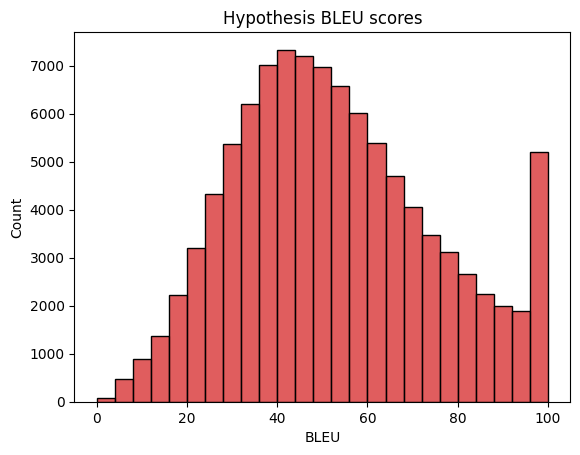

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot
ax = sns.histplot(ds_with_bleu["hypothesis_bleu"], bins=25, color=sns.color_palette()[3])

# ax.set_xlim([.85,1])
# ax.set_ylim([0, 3_000])
ax.set_xlabel("BLEU")
# ax.set_xscale("log")

ax.set_title("Hypothesis BLEU scores")

# save to PDF
# plt.savefig("train_hypothesis_distance_sl128.pdf", format="pdf", bbox_inches="tight") 

## multi-step eval

In [3]:
corr_trainer.num_gen_recursive_steps = 1
corr_trainer.return_best_hypothesis = True

corr_trainer.gen_kwargs = {
    "early_stopping": False,
    "num_beams": 1,
    "do_sample": False,
    "no_repeat_ngram_size": 0,
}
corr_trainer.evaluate(
    eval_dataset=corr_trainer.eval_dataset["msmarco"].select(range(500))
)


/home/jxm3/.conda/envs/torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


generating from val:   0%|                                                                                     | 0/8 [00:00<?, ?it/s]

running manifest on text_list of length 64, first element '*The parking lot will require the use of a separate parking space for the proposed use of the. building. [District Floor Plan: Use of existing floor plan space, dimensions, and/or permit requirements for each. subfloor/driveway will be provided in the Show/Submit Fee Schedule.'


generating from val:  12%|█████████▋                                                                   | 1/8 [00:03<00:25,  3.66s/it]

running manifest on text_list of length 64, first element '3. Download Android data recovery software on your Galaxy S4, S3, S4 or other mobile devices. 4. Once installed, launch the software to recover your data from your Android phone. You can also use it to get back your deleted files.'


generating from val:  25%|███████████████████▎                                                         | 2/8 [00:06<00:19,  3.20s/it]

running manifest on text_list of length 64, first element 'In addition to the income from the investment, a MLP also allows for the depreciation of assets from a source of income through partnerships, real estate, and construction. The MLP structure has been regulated for nearly 90 years. The MLP allows for a significant percentage of the assets to be passed on to the individual investor. To qualify for the MLP, an individual must have at least 70% of its assets from sources of income, such as real estate, construction, and tax-deferred interest income.'


generating from val:  38%|████████████████████████████▉                                                | 3/8 [00:09<00:14,  2.90s/it]

running manifest on text_list of length 64, first element 'The color blue is believed to be a slow-moving color and it is associated with the metabolism. Blues tend to calm down the human mind and cause relaxation. Blue is also believed to produce a deep calming effect.'


generating from val:  50%|██████████████████████████████████████▌                                      | 4/8 [00:11<00:10,  2.74s/it]

running manifest on text_list of length 64, first element 'I think the Pancho Beaches in the Philippines, with their white sand beaches, is in the top list. BANGALOR, GUALAMO, GUALAMO, CUALAMO. I also saw the Pancho Beaches in the world class, so their was not only so amazing.'


generating from val:  62%|████████████████████████████████████████████████▏                            | 5/8 [00:13<00:07,  2.58s/it]

running manifest on text_list of length 64, first element 'This is one of the most famous buildings in the world; it is the Tomb of the Champions. It is located in the center of Paris, just a few minutes away from the famous World Trade Center. It is the site of the famous famous Ritz-Carlton. It stands at a height of 319 meters and it is the tallest structure in the world. It was built in 1939 and was built as a bridge for the famous Paris Opera House. It does not require any special building permits; it is a spire that is surrounded by a cliff.'


generating from val:  75%|█████████████████████████████████████████████████████████▊                   | 6/8 [00:16<00:05,  2.58s/it]

running manifest on text_list of length 64, first element 'The GRE Self Study Book (with a budget of $20) You can learn a lot if youâre a seasoned LEARN. The only good recommendation: buy one book for just one book. If you want to save money, you might want to consider buying the GRE self study book too.'


generating from val:  88%|███████████████████████████████████████████████████████████████████▍         | 7/8 [00:18<00:02,  2.56s/it]

running manifest on text_list of length 52, first element 'But there was a moment in the book when he explains that he was the most famous shooter on American soil: Kyle's rifle was snubbed by an insurgent in Iraq, thereby helping him to defeat the snatchers. In the video, he describes how he swam down the pool with a snatcher.'


[pred] *The parking lot will require the use of a separate parking space for the proposed use of the. building. [District Floor Plan: Use of existing floor plan space, dimensions, and/or permit requirements for each. subfloor/driveway will be provided in the Show/Submit Fee Schedule.
[true] *The use of the driveway as the required parking spaces will require a separate submittal for a Use Permit. [ ] Floor plan (dimensioned): Show overall building size, existing and proposed room locations, existing and. proposed new window(s)/door(s) size/location(s).



[pred] Our illuminated Seville map is encapsulated in a map of each of our cities, enabling you to discover hidden gems of the city. Our enlightened Seville map also includes a map of the SEGA STREET, the central business district, the AIRPORT, the CORTESTA and the GARDENWAY.e encourage you to take advantage of our easy-to-use, fully accessible and fully accessible map of Seville, allowing you to explore the city in a completely unclu

{'eval_loss': 1.925140142440796,
 'eval_pred_num_tokens': 80.65625,
 'eval_true_num_tokens': 80.859375,
 'eval_token_set_precision': 0.5306075166380131,
 'eval_token_set_recall': 0.6181320146541678,
 'eval_token_set_f1': 0.5655370273875632,
 'eval_bleu_score': 18.22941838538746,
 'eval_meteor_score': 0.4322368810647787,
 'eval_rouge_score': 0.5518874345017427,
 'eval_exact_match': 0.006,
 'eval_emb_cos_sim': 0.9555368423461914,
 'eval_runtime': 36.739,
 'eval_samples_per_second': 13.61,
 'eval_steps_per_second': 0.218}

In [4]:
corr_trainer.num_gen_recursive_steps = 10
corr_trainer.return_best_hypothesis = True

corr_trainer.gen_kwargs = {
    "early_stopping": False,
    "num_beams": 1,
    "do_sample": False,
    "no_repeat_ngram_size": 0,
}
corr_trainer.evaluate(
    eval_dataset=corr_trainer.eval_dataset["msmarco"].select(range(500))
)


generating from val:   0%|                                                                                     | 0/8 [00:00<?, ?it/s]

running manifest on text_list of length 64, first element '*The parking lot will require the use of a separate parking space for the proposed use of the. building. [District Floor Plan: Use of existing floor plan space, dimensions, and/or permit requirements for each. subfloor/driveway will be provided in the Show/Submit Fee Schedule.'
running manifest on text_list of length 64, first element '*The proposed use of the parking space will require a separate parking space for the. building. [District Floor Plan: Use of existing floor plan space, dimensions, and/or permit requirements for each. subfloor/driveway will be provided in the Show/Submit Fee Schedule.'
running manifest on text_list of length 64, first element '*The proposed use of the parking space will require a separate parking space for the. building. [District Floor Plan: Use of existing floor plan space, dimensions, and/or permit requirements for each. subfloor/driveway will be provided in the Show/Submit Fee Schedule.'
runn

generating from val:  12%|█████████▋                                                                   | 1/8 [00:25<02:58, 25.53s/it]

running manifest on text_list of length 64, first element '3. Download Android data recovery software on your Galaxy S4, S3, S4 or other mobile devices. 4. Once installed, launch the software to recover your data from your Android phone. You can also use it to get back your deleted files.'
running manifest on text_list of length 64, first element '3. Install Android data recovery software on your Galaxy S4, S3, S4 or other mobile devices. 4. Once installed, launch the software to recover your data from your Android phone. You can also use it to get back your deleted files.'
running manifest on text_list of length 64, first element '3. Install Android data recovery software on your Galaxy S4, S3, S4 or other mobile devices. 4. Once installed, launch the software to get back your lost data (example your Android phone or computer).'
running manifest on text_list of length 64, first element '3. Install Android data recovery software on your Galaxy S4, S3, S4 or other mobile devices. 4. Onc

generating from val:  25%|███████████████████▎                                                         | 2/8 [00:52<02:36, 26.13s/it]

running manifest on text_list of length 64, first element 'In addition to the income from the investment, a MLP also allows for the depreciation of assets from a source of income through partnerships, real estate, and construction. The MLP structure has been regulated for nearly 90 years. The MLP allows for a significant percentage of the assets to be passed on to the individual investor. To qualify for the MLP, an individual must have at least 70% of its assets from sources of income, such as real estate, construction, and tax-deferred interest income.'
running manifest on text_list of length 64, first element 'In addition to the income from the investment, a MLP also allows for the depreciation of assets from a source of income through partnerships, such as real estate, construction, and leasing. The taxation of MLP assets has been a significant area of focus for the past 90 years. To qualify for the MLP, an investor must pass through at least 70% of its assets from sources of income

generating from val:  38%|████████████████████████████▉                                                | 3/8 [01:18<02:12, 26.42s/it]

running manifest on text_list of length 64, first element 'The color blue is believed to be a slow-moving color and it is associated with the metabolism. Blues tend to calm down the human mind and cause relaxation. Blue is also believed to produce a deep calming effect.'
running manifest on text_list of length 64, first element 'The color blue is believed to be a slow-moving color and it is associated with metabolic efficiency and calmness. Blues tend to calm the human mind and cause deep relaxation, which is believed to produce a calm emotion.'
running manifest on text_list of length 64, first element 'The color blue is believed to slow down the metabolism and calmness and it is associated with metabolic efficiency. Blue is often thought to produce a deep understanding of the human mind, which is associated with calmness and warmth.'
running manifest on text_list of length 64, first element 'The color blue is believed to slow down the processing of emotions and it is associated with m

generating from val:  50%|██████████████████████████████████████▌                                      | 4/8 [01:42<01:41, 25.39s/it]

running manifest on text_list of length 64, first element 'I think the Pancho Beaches in the Philippines, with their white sand beaches, is in the top list. BANGALOR, GUALAMO, GUALAMO, CUALAMO. I also saw the Pancho Beaches in the world class, so their was not only so amazing.'
running manifest on text_list of length 64, first element 'I think the Pancho Beaches in the Philippines, with their white sand beaches, is in the top list. BANGALOR, GUALAMO, GUALAMO, CUALAMO. I also saw the Pancho Island in the world class, so their was not only so amazing.'
running manifest on text_list of length 64, first element 'I think the Pancho Beaches in the Philippines, with their white sand beaches, is in the top list. BANGALOR, GUALAMO, GUALAMO, CUALAMO. I also saw the Pancho Island in the world class, so their was not only so amazing.'
running manifest on text_list of length 64, first element 'I think the Pancho Beaches in the Philippines, with their white sand beaches, is in the top list. BANGALOR

generating from val:  62%|████████████████████████████████████████████████▏                            | 5/8 [02:16<01:25, 28.34s/it]

running manifest on text_list of length 64, first element 'This is one of the most famous buildings in the world; it is the Tomb of the Champions. It is located in the center of Paris, just a few minutes away from the famous World Trade Center. It is the site of the famous famous Ritz-Carlton. It stands at a height of 319 meters and it is the tallest structure in the world. It was built in 1939 and was built as a bridge for the famous Paris Opera House. It does not require any special building permits; it is a spire that is surrounded by a cliff.'
running manifest on text_list of length 64, first element 'This is one of the most famous buildings in the world; it is the Tomb of the Champions. It is located in the center of Paris, just a few minutes away from the famous World Trade Center. It is the site of Katie Holmesâ famous proposal to build the World Trade Center. It stands at a height of 319 meters and it is the tallest structure in the world. It does not require any special buildi

generating from val:  75%|█████████████████████████████████████████████████████████▊                   | 6/8 [02:42<00:55, 27.57s/it]

running manifest on text_list of length 64, first element 'The GRE Self Study Book (with a budget of $20) You can learn a lot if youâre a seasoned LEARN. The only good recommendation: buy one book for just one book. If you want to save money, you might want to consider buying the GRE self study book too.'
running manifest on text_list of length 64, first element 'The GRE Self Study Book (with a budget of $20) You can learn a lot if youâre a seasoned LEARN. The only good recommendation: buy one book for just $20. You probably wonât spend more than $120 to read this book, but you might want to pick up the book.'
running manifest on text_list of length 64, first element 'The GRE Self Study Book (with a budget of $20) You can learn a lot if you only plan to take one GRE grad LEARN. The only good recommendation: buy one book for less than $20. You probably wonât spend more than $120 to pick up the book.'
running manifest on text_list of length 64, first element 'The GRE Self Study Book (wit

generating from val:  88%|███████████████████████████████████████████████████████████████████▍         | 7/8 [03:07<00:26, 26.95s/it]

running manifest on text_list of length 52, first element 'But there was a moment in the book when he explains that he was the most famous shooter on American soil: Kyle's rifle was snubbed by an insurgent in Iraq, thereby helping him to defeat the snatchers. In the video, he describes how he swam down the pool with a snatcher.'
running manifest on text_list of length 52, first element 'But there was a moment in the book when he explains that he was the most deadly shooter on American soil: Kyle's autoswivels were fired upon an insurgent in Iraq, thereby helping him to defeat the snatchers. In the video, he describes how he swam down the pool with a snatcher.'
running manifest on text_list of length 52, first element 'But there was a moment in the book when he explains that he was the most deadly shooter on American soil: In the movie, Kyle's autoswivels were fired upon an insurgent in Iraq, thereby helping him to defeat the snatchers and make a humanitarian mission.'
running manifest 

[pred] *The proposed use of the parking space will require a separate parking space for the. building. [District Floor Plan: Use of existing floor plan space, dimensions, and/or permit requirements for each. subfloor/driveway will be provided in the Show/Submit Fee Schedule.
[true] *The use of the driveway as the required parking spaces will require a separate submittal for a Use Permit. [ ] Floor plan (dimensioned): Show overall building size, existing and proposed room locations, existing and. proposed new window(s)/door(s) size/location(s).



[pred] Our illuminated Seville map is encapsulated in a map of each of these cities, enabling you to discover hidden gems of the city. Our enlightened Seville map also includes a map of the SEGA STREET, the central business district, the AIRPORT, the CORTESTA and the GARDENWAY.our fully accessible street corners and streets are clearly marked with a distinctive street address, allowing you to explore the city in a completely uncluttered manner

{'eval_loss': 1.925140142440796,
 'eval_pred_num_tokens': 78.703125,
 'eval_true_num_tokens': 80.859375,
 'eval_token_set_precision': 0.5598354732342954,
 'eval_token_set_recall': 0.6348265787981741,
 'eval_token_set_f1': 0.5902981326128126,
 'eval_bleu_score': 19.35778063425997,
 'eval_meteor_score': 0.45755907554270014,
 'eval_rouge_score': 0.5816473631153447,
 'eval_exact_match': 0.006,
 'eval_emb_cos_sim': 0.962153971195221,
 'eval_runtime': 225.2168,
 'eval_samples_per_second': 2.22,
 'eval_steps_per_second': 0.036}

In [3]:
corr_trainer.args.per_device_eval_batch_size = 32
corr_trainer.num_gen_recursive_steps = 5
corr_trainer.return_best_hypothesis = True

corr_trainer.gen_kwargs = {
    "early_stopping": False,
    "num_beams": 4,
    "num_return_sequences": 4,
    "do_sample": False,
    "no_repeat_ngram_size": 0,
}
corr_trainer.evaluate(
    eval_dataset=corr_trainer.eval_dataset["msmarco"].select(range(500))
)


/home/jxm3/.conda/envs/torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


generating from val:   0%|                                                                                    | 0/16 [00:00<?, ?it/s]

running manifest on text_list of length 128, first element '*The parking lot will require the use of a separate parking space for the proposed use of the. building. [District Floor Plan: Use of existing floor plan space, dimensions, and/or permit requirements for each. subfloor/space will be provided in the Submitting Documents.'
running manifest on text_list of length 128, first element '*The parking lot will require the use of a separate parking space for the proposed use of the. building. [District Floor Plan: Use of existing floor plan space, dimensions, and/or permit requirements for each. subfloor/space will be provided in the Submitting Documents.'
running manifest on text_list of length 128, first element '*The parking lot will require the use of a separate parking space for the proposed use of the. building. [District Floor Plan: Use of existing floor plan space, dimensions, and/or permit requirements for each. subfloor/space will be provided in the Submit Documents.'
running 

generating from val:   6%|████▊                                                                       | 1/16 [00:25<06:26, 25.79s/it]

running manifest on text_list of length 128, first element 'When you list your expertise, you pay the buyer's agent, and the seller's agent, who is the real estate sales agent! When you're buying a home, you get to choose between paying your agent and the buyer's agent. No need to learn the ins and outs of selling! Both of you get paid for their expertise!'
running manifest on text_list of length 128, first element 'When you list your expertise, you pay the buyer's agent, and the seller's agent, who is the real estate sales agent! When you're buying, you get to choose between paying your agent and the buyer's agent. No need to learn the ins and outs of selling!'
running manifest on text_list of length 128, first element 'When you list your expertise, you pay the buyer's agent, and the seller's agent, who is the real estate sales agent! When you're buying, you get to choose between paying your agent and the buyer's agent. No need to learn the ins and outs of selling! Both of you get pai

generating from val:  12%|█████████▌                                                                  | 2/16 [00:53<06:15, 26.83s/it]

running manifest on text_list of length 128, first element '3. Download Android data recovery software on your Android phone. 4. To recover deleted data from your Android phone, install or launch the software on your Samsung Galaxy S4, Galaxy S3, or other devices, you can also use it to get back your old data.'
running manifest on text_list of length 128, first element '3. Download Android data recovery software on your Android phone. 4. To recover your data from your Android phone, install or launch the software on your Samsung Galaxy S4, Galaxy S3, or other devices, then use it to back up your files.'
running manifest on text_list of length 128, first element '3. Install Android data recovery software on your Android phone (Samsung Galaxy S4, S3, S4, S5, S3, or other devices). 4. Once your Android phone has been lost or deleted, use it to get back your data.'
running manifest on text_list of length 128, first element '3. Install Android data recovery software on your Android phone (S

generating from val:  19%|██████████████▎                                                             | 3/16 [01:18<05:37, 25.96s/it]

running manifest on text_list of length 128, first element 'Etymology & Historical Origin. By 'logistic', the term 'logistic' is very similar to the term 'logging'. The purpose of chucking is to seal the interior of a structure with a thin, sanded-down log wall.This process is done to seal the inside of a structure with a thin, sanded-down log wall.n the same way, chucking is very similar to the term 'logistic'. The purpose of chucking is to seal the interior of'
running manifest on text_list of length 128, first element 'Etymology & Historical Origin. By 'login', the term 'login' is very similar to the term 'logging'. The purpose of login chipping is to seal the interior of a structure with a thin, well-preserved log wall.This process is done to seal the inside of a structure with a thin, well-preserved log wall.he purpose of login chipping is to seal the interior of a structure with a thin, well-preserved log wall. This process is done'
running manifest on text_list of length 128, fi

generating from val:  25%|███████████████████                                                         | 4/16 [01:41<04:58, 24.85s/it]

running manifest on text_list of length 128, first element 'In addition to qualifying income from the investment, a MLP also allows for the depreciation of assets from a source of income, such as real estate, construction, and partnership structures. MLPs have been regulated for over 90 years. The MLP allows for a significant percentage of the assets to be passed on to the individual investor. The MLP must have at least 70% of its assets from sources of income.'
running manifest on text_list of length 128, first element 'In addition to qualifying income from the investment, a MLP also allows for the depreciation of assets through a variety of sources, such as real estate, construction, and partnership structures. MLPs have been beneficial to investors for over 90 years. The MLP allows for a significant percentage of the assets to be passed on to the individual investor. The MLP must have at least 70% of its assets from sources of income.'
running manifest on text_list of length 128, fi

generating from val:  31%|███████████████████████▊                                                    | 5/16 [02:09<04:45, 25.99s/it]

running manifest on text_list of length 128, first element 'The services provided by Walk-In Health Care are provided by a private practice of Dr. DâAndrew R. Dow, a licensed physician in New York City, and a member of the New York City medical group of independent physicians, who are not employees of Walk-In Health Care, a subsidiary of Walgreens, Inc., or any of its affiliates...'
running manifest on text_list of length 128, first element 'The services provided by Take Care New York are provided by a private practice of Dr. DâAndrew R. Dow, a licensed physician in New York City, and a member of the Take Care New York medical group of independent physicians, who are not employees of Walk-In Health Care, a subsidiary of Walgreens, Inc., or any of its affiliates...'
running manifest on text_list of length 128, first element 'The services provided by Walk-In Health Care are provided by a private practice of Dr. DâAndrew R. Dow, a licensed physician in New York City, and a member of the T

generating from val:  38%|████████████████████████████▌                                               | 6/16 [02:40<04:37, 27.75s/it]

running manifest on text_list of length 128, first element 'The color blue is believed to be a slow-moving color and it is associated with the human metabolism. Blues tend to calm down the human mind and cause relaxation. Blue is also believed to represent calmness and energy.'
running manifest on text_list of length 128, first element 'The color blue is believed to be calming and slow-moving and it is associated with the human metabolism. Blue is often believed to produce a deep feeling of calmness that symbolizes knowledge and understanding.'
running manifest on text_list of length 128, first element 'The color blue is believed to be calming and slow-moving and it is associated with the human metabolism. Blue is often believed to produce a deep euphoria that symbolizes knowledge, calmness and calmness.'
running manifest on text_list of length 128, first element 'The color blue is believed to be calming and slow-moving and it is associated with the human metabolism. Blue is often beli

generating from val:  44%|█████████████████████████████████▎                                          | 7/16 [03:24<04:56, 32.90s/it]

running manifest on text_list of length 128, first element 'Temperate Grasslands Temperate grasslands are characterized as having fewer trees than shrubs and shrubs. Seasonal rainfall is predominant in the temperate savanna. Grasslands are often distinguished from other grasslands because of their large number of trees.'
running manifest on text_list of length 128, first element 'Temperate Grasslands Temperate grasslands are characterized as having a large number of trees and shrubs. Seasonal rainfall is predominant, as temperatures rarely change from summer to winter. Grasslands are also known as desert grasslands.'
running manifest on text_list of length 128, first element 'Temperate Grasslands Temperate grasslands are characterized as having fewer trees and shrubs than the grassland. Seasonal rainfall is predominant, as temperatures rarely change from summer to winter. Grasslands are also known as prairies because of the savanna vegetation.'
running manifest on text_list of length 1

generating from val:  50%|██████████████████████████████████████                                      | 8/16 [03:54<04:16, 32.03s/it]

running manifest on text_list of length 128, first element 'I think the Pancho Beaches in the Philippines, with their white sand beaches, should be in the top list. BANGALOR, GUALAMO, GUALAMO, GUALAMO. I also saw the Pancho Island in Cameroon. Its not only amazing, but also so beautiful.'
running manifest on text_list of length 128, first element 'I think the Pancho Beaches in the Philippines, with their white sand beaches, should be in the top list. BANGALOR, GUALAMO, GUALAMO, GUALAMO. I also saw the Pancho Island in Cameroon. Its not only amazing, but also so great.'
running manifest on text_list of length 128, first element 'I think the Pancho Beaches in the Philippines, with their white sand beaches, should be in the top list. BANGALOR, GUALAMO, GUALAMO, GUALAMO. I also saw the Pancho Island in Cameroon. Its not only amazing, but also so much.'
running manifest on text_list of length 128, first element 'I think the Pancho Beaches in the Philippines, with their white sand beaches, s

generating from val:  56%|██████████████████████████████████████████▊                                 | 9/16 [04:20<03:32, 30.37s/it]

running manifest on text_list of length 128, first element '1 The vitamin B6 that causes vertigo appears to reduce nausea and vomiting. Look for foods that contain more vitamin B6 such as spinach, kale, dandelion, apricots, walnuts, peanuts, peanut butter, chicken, pork, fish, eggs, nuts and fish-based breakfast cereals that add calcium to your diet.'
running manifest on text_list of length 128, first element '1 The vitamin B6 that causes vertigo appears to reduce nausea and vomiting. Look for foods that contain more vitamin B6 such as spinach, kale, dandelion, apricots, walnuts, peanuts, chicken, pork, fish, eggs, nuts and fish-based breakfast cereals that add calcium to your diet.'
running manifest on text_list of length 128, first element '1 The vitamin B6 that causes vertigo appears to reduce nausea and vomiting. To add more vitamin B6 to your diet, look for foods that contain dandelion, such as apricots, walnuts, peanuts, peanut butter, chicken, pork, fish, eggs, nuts and fish-bas

generating from val:  62%|██████████████████████████████████████████████▉                            | 10/16 [04:46<02:52, 28.74s/it]

running manifest on text_list of length 128, first element 'This is one of the most famous buildings in the world; it is the Tomb of the Champions. It is located in the center of Paris, just a few minutes away from the famous World Trade Center. It is the site of Katie Holmesâ famous introduction to the world. It stands at a height of 319 meters and it is the tallest structure in the world. It was built in 1939 and was built as a bridge for the famous Paris Opera House. It does not require any special building permits; it is one of the most famous buildings in the world.'
running manifest on text_list of length 128, first element 'This is one of the most famous buildings in the world; it is the Tomb of the Champions. It is located in the center of Paris, just a few minutes away from the famous World Trade Center. It is the site of Katie Holmesâ famous introduction to the world. It stands at a height of 319 meters and it is the tallest structure in the world. It was built as a bridge fo

generating from val:  69%|███████████████████████████████████████████████████▌                       | 11/16 [05:10<02:16, 27.36s/it]

running manifest on text_list of length 128, first element 'At the age of 17, a child can no longer move out of the home of their parents. There is no police in Michigan that can bring a child home. As a parent you can help your child move out of the home of your parents. At the age of 17, a child can no longer move out of the home of their parents. There is no police in Michigan that can bring a child home. As a parent you can help your child move out of the home of your parents.'
running manifest on text_list of length 128, first element 'At the age of 17 a child can move out of the home of their parents. There is no police in Michigan that can bring a child home. As a parent you can help your child move out of the home of their parents. At the age of 17 a child can move out of the home of their parents. There is no police in Michigan that can bring a child home. As a parent you can help your child move out of the home of their parents.'
running manifest on text_list of length 128, f

generating from val:  75%|████████████████████████████████████████████████████████▎                  | 12/16 [05:36<01:47, 26.99s/it]

running manifest on text_list of length 128, first element 'The GRE Self Study Book (with a good plan) You can learn a lot if youâre a LEARN only student. The cost of this book is less than $20 for just one book. If you want to save money, you might want to consider buying the GRE self study book for $20.'
running manifest on text_list of length 128, first element 'Cost of the GRE Self Study Book (with a good plan) You can learn a lot if youâre a LEARN only grad student. Guess how much youâll spend for just one book. If you want to save money, you might want to consider buying the GRE self-study book for $20.'
running manifest on text_list of length 128, first element 'Cost of the GRE Self-Study Book (with a budget of $20) You can learn a lot if youâre a LEARN only grad student. Guess how much youâll spend for just one book. If you donât mind spending more money, you might want to pick up one of the GRE self-study books.'
running manifest on text_list of length 128, first element 'Cost

generating from val:  81%|████████████████████████████████████████████████████████████▉              | 13/16 [06:02<01:20, 26.70s/it]

running manifest on text_list of length 128, first element 'Indianapolis Public Schools Statement of Equal Opportunity. Indianapolis Public Schools is an equal opportunity employer committed to ensuring the quality of education and employment for all students. IPS strives to deliver a socially equitable and equitable learning experience to our students and their families.'
running manifest on text_list of length 128, first element 'Indianapolis Public Schools Statement of Diversity. IPS is an equal opportunity employer committed to delivering quality education and employment to our students, families, and communities. IPS strives to recognize and address social equity through equitable learning.'
running manifest on text_list of length 128, first element 'IPS Statement of Equal Opportunity. Indianapolis Public Schools is an equal opportunity employer committed to delivering quality education and employment to our students, families, and communities. IPS strives to recognize and address

generating from val:  88%|█████████████████████████████████████████████████████████████████▋         | 14/16 [06:25<00:51, 25.62s/it]

running manifest on text_list of length 128, first element 'But there was a moment in the book when he explains that he shot down the most-infamous sniper on American soil: Kyle was snubbed by an instructor in the air during a military mission in Iraq, thereby helping him to defeat the snatchers. In the book, he explains that he is a self-defense snatcher.'
running manifest on text_list of length 128, first element 'But there was a moment in the book when he explains that he shot down the most-infamous volley on American beach: Kyle was shot by an insurgent in the air during a military mission in Iraq, thereby helping him to defeat the snatchers.'
running manifest on text_list of length 128, first element 'But there was a moment in the book when he explains that he shot down the most-infamous volley on American beach: When Kyle was shot by an insurgent in the air during a military mission in Iraq, thereby helping him to defeat the snatchers. In the autobiography, he identifies himself 

generating from val:  94%|██████████████████████████████████████████████████████████████████████▎    | 15/16 [06:48<00:24, 24.87s/it]

running manifest on text_list of length 80, first element 'In United States law, adjournment of dismissal (ACD) is sometimes contemplated as a court adjournment for a period of time, usually six months, to allow the defendant to conclude the case in the interest of a plea of guilty or to reduce the criminal charge to a lesser charge. The defendant may be dismissed by the judge without...'
running manifest on text_list of length 80, first element 'In United States law, adjournment of dismissal (ACD) is sometimes contemplated as a criminal adjournment for a period of time, usually six months, to allow the defendant to conclude the case in the interest of a plea of guilty or to reduce the criminal charge to a later charge. The defendant may be dismissed by the judge without...'
running manifest on text_list of length 80, first element 'In United States law, adjournment of dismissal (ACD) is sometimes contemplated as a criminal adjournment for a period of time, usually six months, to allow

[pred] *The parking lot will require the use of a separate parking space for the proposed use of the. building. [District Floor Plan: Use of existing permit space, dimensions, and/or permit requirements for each. subfloor/space will be shown in the Submit Documents.
[true] *The use of the driveway as the required parking spaces will require a separate submittal for a Use Permit. [ ] Floor plan (dimensioned): Show overall building size, existing and proposed room locations, existing and. proposed new window(s)/door(s) size/location(s).



[pred] Our illuminated Seville map is encapsulated in a map of each of our cities, enabling you to discover the hidden gems of the city. Our enlightened Seville map also includes a map of the streets of the city centre, the central business district, the outskirts of the city center and the streets of Cartagena.e encourage you to take advantage of our easy-to-use, fully accessible and easy-to-understand street maps of Valencia, Costa Rica and Spain.
[t

{'eval_loss': 1.9263066053390503,
 'eval_pred_num_tokens': 80.65625,
 'eval_true_num_tokens': 80.859375,
 'eval_token_set_precision': 0.5718026222808328,
 'eval_token_set_recall': 0.6471834478722946,
 'eval_token_set_f1': 0.602151840385882,
 'eval_bleu_score': 20.363485712345508,
 'eval_meteor_score': 0.4635260268263805,
 'eval_rouge_score': 0.5908035883250253,
 'eval_exact_match': 0.012,
 'eval_emb_cos_sim': 0.9642256498336792,
 'eval_runtime': 441.3494,
 'eval_samples_per_second': 1.133,
 'eval_steps_per_second': 0.036}